In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob

In [2]:
all_image_path = glob.glob('dataset/2_class/*/*.jpg')

In [3]:
all_image_path[:5]

['dataset/2_class\\airplane\\airplane_001.jpg',
 'dataset/2_class\\airplane\\airplane_002.jpg',
 'dataset/2_class\\airplane\\airplane_003.jpg',
 'dataset/2_class\\airplane\\airplane_004.jpg',
 'dataset/2_class\\airplane\\airplane_005.jpg']

In [4]:
all_image_path[-5:]

['dataset/2_class\\lake\\lake_696.jpg',
 'dataset/2_class\\lake\\lake_697.jpg',
 'dataset/2_class\\lake\\lake_698.jpg',
 'dataset/2_class\\lake\\lake_699.jpg',
 'dataset/2_class\\lake\\lake_700.jpg']

In [5]:
import random

In [6]:
random.shuffle(all_image_path)

In [7]:
all_image_path[:5]

['dataset/2_class\\lake\\lake_439.jpg',
 'dataset/2_class\\airplane\\airplane_512.jpg',
 'dataset/2_class\\lake\\lake_397.jpg',
 'dataset/2_class\\lake\\lake_143.jpg',
 'dataset/2_class\\lake\\lake_432.jpg']

In [8]:
label_to_index = {'airplane':0, 'lake':1}

In [9]:
index_to_label = dict((v,k) for k,v in label_to_index.items())

In [10]:
index_to_label

{0: 'airplane', 1: 'lake'}

In [11]:
img = all_image_path[100]

In [12]:
label_to_index.get(img.split('\\')[1])

0

In [13]:
all_labels = [label_to_index.get(img.split('\\')[1]) for img in all_image_path]

In [14]:
all_image_path[-5:]

['dataset/2_class\\airplane\\airplane_438.jpg',
 'dataset/2_class\\lake\\lake_426.jpg',
 'dataset/2_class\\airplane\\airplane_010.jpg',
 'dataset/2_class\\airplane\\airplane_592.jpg',
 'dataset/2_class\\airplane\\airplane_007.jpg']

In [15]:
all_labels[-5:]

[0, 1, 0, 0, 0]

In [16]:
img

'dataset/2_class\\airplane\\airplane_025.jpg'

In [17]:
img_raw = tf.io.read_file(img)

In [18]:
img_tensor = tf.image.decode_jpeg(img_raw)

In [19]:
img_tensor.shape

TensorShape([256, 256, 3])

In [20]:
img_tensor.dtype

tf.uint8

In [21]:
img_tensor = tf.cast(img_tensor,tf.float32)

In [22]:
img_tensor = img_tensor/255.0

In [23]:
img_tensor.numpy().max()

1.0

In [24]:
img_tensor.numpy().min()

0.0

In [25]:
def load_and_preprocess_img(path):
    img_raw = tf.io.read_file(path)
    img_tensor = tf.image.decode_jpeg(img_raw,channels=3)
    img_tensor = tf.image.resize(img_tensor,[256,256])
    img_tensor = tf.cast(img_tensor,tf.float32)
    img_tensor = img_tensor/255.0
    return img_tensor

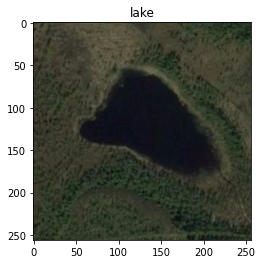

In [26]:
i = random.choice(range(len(all_image_path)))
img_path = all_image_path[i]
label = all_labels[i]

img_tensor = load_and_preprocess_img(img_path)

plt.title(index_to_label.get(label))
plt.imshow(img_tensor.numpy())

In [27]:
img_ds = tf.data.Dataset.from_tensor_slices(all_image_path)

In [28]:
img_ds = img_ds.map(load_and_preprocess_img)

In [29]:
img_ds

<MapDataset shapes: (256, 256, 3), types: tf.float32>

In [30]:
label_ds = tf.data.Dataset.from_tensor_slices(all_labels)

In [31]:
label_ds

<TensorSliceDataset shapes: (), types: tf.int32>

In [32]:
for label in label_ds.take(10):
    print(index_to_label.get(label.numpy()))

lake
airplane
lake
lake
lake
airplane
lake
lake
airplane
airplane


In [33]:
img_lable_ds = tf.data.Dataset.zip((img_ds,label_ds)) #元组形式输入

In [34]:
img_lable_ds

<ZipDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>

In [35]:
image_count = len(all_image_path)

In [36]:
test_count  = int(image_count*0.2)
train_count = image_count-test_count

In [37]:
train_ds = img_lable_ds.skip(test_count)
test_ds = img_lable_ds.take(test_count)

In [38]:
batch_size = 16

In [39]:
train_ds = train_ds.repeat().shuffle(100).batch(batch_size) #重复输入数据，100大小缓存区乱序，小批次

In [40]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [41]:
test_ds = test_ds.batch(batch_size)

## 模型的创建（卷积）

In [42]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64,(3,3),input_shape=(256,256,3),activation='relu'))
#64卷积核，3*3大小
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D())

model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
#batch hight width channel =>batch channal

model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

<img src="https://img-blog.csdnimg.cn/20200312000813310.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L1JvY2t5NjY4OA==,size_16,color_FFFFFF,t_70" style="zoom:33%;" />

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [44]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['acc']
)

In [45]:
steps_per_epoch = train_count//batch_size
val_step = test_count//batch_size

In [46]:
history = model.fit(
    train_ds,epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_ds,
    validation_steps=val_step
    )

Epoch 1/10
70/70 [==============================] - 42s 593ms/step - loss: 0.4295 - acc: 0.8214 - val_loss: 0.2796 - val_acc: 0.9007
Epoch 2/10
70/70 [==============================] - 42s 599ms/step - loss: 0.2703 - acc: 0.9196 - val_loss: 0.2185 - val_acc: 0.9412
Epoch 3/10
70/70 [==============================] - 42s 603ms/step - loss: 0.2084 - acc: 0.9366 - val_loss: 0.2188 - val_acc: 0.9375
Epoch 4/10
70/70 [==============================] - 43s 610ms/step - loss: 0.2179 - acc: 0.9277 - val_loss: 0.1367 - val_acc: 0.9559
Epoch 5/10
70/70 [==============================] - 43s 612ms/step - loss: 0.1936 - acc: 0.9411 - val_loss: 0.1258 - val_acc: 0.9632
Epoch 6/10
70/70 [==============================] - 43s 615ms/step - loss: 0.1731 - acc: 0.9482 - val_loss: 0.1148 - val_acc: 0.9669
Epoch 7/10
70/70 [==============================] - 43s 616ms/step - loss: 0.1578 - acc: 0.9536 - val_loss: 0.3063 - val_acc: 0.8971
Epoch 8/10
70/70 [==============================] - 43s 614ms/step - 

In [47]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

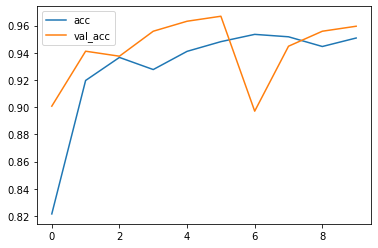

In [48]:
plt.plot(history.epoch,history.history.get('acc'),label='acc')
plt.plot(history.epoch,history.history.get('val_acc'),label='val_acc')
plt.legend()

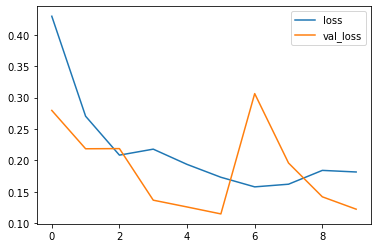

In [49]:
plt.plot(history.epoch,history.history.get('loss'),label='loss')
plt.plot(history.epoch,history.history.get('val_loss'),label='val_loss')
plt.legend()

## 使用模型预测

In [50]:
image_path = 'dataset/2_class/test02.png'
img = load_and_preprocess_img(image_path)

In [51]:
img.shape

TensorShape([256, 256, 3])

In [52]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [53]:
img = tf.expand_dims(img,axis=0)

In [54]:
img.shape

TensorShape([1, 256, 256, 3])

In [55]:
pred = model.predict(img)

In [56]:
index_to_label.get((pred>0.5).astype('int')[0][0])

'airplane'

In [57]:
def pred_img(image_path):
    img = load_and_preprocess_img(image_path)
    plt.imshow(img)
    img = tf.expand_dims(img,axis=0)
    pred = model.predict(img)
    print(index_to_label.get((pred>0.5).astype('int')[0][0]))


lake


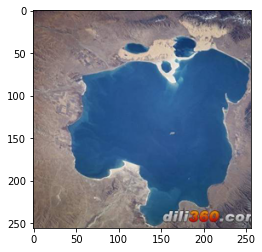

In [58]:
pred_img('dataset/2_class/test01.png')